In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

In [5]:
mnist_train = datasets.CIFAR10("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.CIFAR10("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def standard_epoch(data_loader, model, loss_fn, optimizer = None):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #get the model prediction
        y_pred = model(X)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)
        

In [7]:
def adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, optimizer=None, **kwargs):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #generate adversarial perturbation
        delta = attack_fn(model, X, y, loss_fn, epsilon, **kwargs)
        X_adv = X + delta
        
        #get the model prediction on the adversarial example
        y_pred = model(X_adv)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)

In [8]:
#define attack method that we will use to train our robust model
def pgd_linf(model, X, y, loss_fn, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [9]:
def train_robust_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, attack_fn, epsilon, **kwargs):
    train_losses = []
    test_losses = []
    adv_losses = []
    train_accuracies = []
    test_accuracies = []
    adv_accuracies = []
    
    print(*(i.format(i) for i in ("Train Loss", "Test Loss", "Adv Loss", "Train Accuracy", "Test Accuracy", "Adv Accuracy")), sep="\t")
    for epoch in range(num_epochs):
        #train the model on adversarial constructed examples
        train_loss, train_accuracy = adversarial_epoch(train_loader, model, loss_fn, attack_fn, epsilon, optimizer, **kwargs)
        #evaluate the model on the test set
        test_loss, test_accuracy = standard_epoch(test_loader, model, loss_fn)
        #evaluate the model on adversarial examples
        adv_loss, adv_accuracy = adversarial_epoch(test_loader, model, loss_fn, attack_fn, epsilon, **kwargs)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        adv_losses.append(adv_loss)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        adv_accuracies.append(adv_accuracy)
        
        print(*("{:.6f}".format(i) for i in (train_loss, test_loss, adv_loss, train_accuracy, test_accuracy, adv_accuracy)), sep="\t")
        
    return [train_losses, test_losses, adv_losses, train_accuracies, test_accuracies, adv_accuracies]

In [10]:
def plot_model_training(train_losses, test_losses, adv_losses, train_accuracies, test_accuracies, adv_accuracies, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    plt.suptitle(title)

    axs[0].plot(train_losses, label="Train")
    axs[0].plot(test_losses, label="Test")
    axs[0].plot(adv_losses, label="Adv")
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(train_accuracies, label="Train")
    axs[1].plot(test_accuracies, label="Test")
    axs[1].plot(adv_accuracies, label="Adv")
    axs[1].set_title("Accuracy")
    axs[1].legend()

    plt.show()

In [11]:
#define the models

#Define 4 different models for evaluation

model_shallow_dnn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 128),
    nn.GELU(),
    nn.Linear(128, 10)
).to(device)
shallow_dnn_optimizer = optim.Adam(model_shallow_dnn.parameters(), lr=0.001)

model_deep_dnn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 512),
    nn.GELU(),
    nn.Linear(512, 256),
    nn.GELU(),
    nn.Linear(256, 128),
    nn.GELU(),
    nn.Linear(128, 10)
).to(device)
deep_dnn_optimizer = optim.Adam(model_deep_dnn.parameters(), lr=0.001)

model_standard_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(1600, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
standard_cnn_optimizer = optim.Adam(model_standard_cnn.parameters(), lr=0.001)

#include some dropout layers and batch normalization
model_complex_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.5),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.5),
    nn.Flatten(),
    nn.Linear(1600, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
complex_cnn_optimizer = optim.Adam(model_complex_cnn.parameters(), lr=0.001)

models = [
    (model_shallow_dnn, shallow_dnn_optimizer, "Shallow DNN"),
    (model_deep_dnn, deep_dnn_optimizer, "Deep DNN"),
    (model_standard_cnn, standard_cnn_optimizer, "Standard CNN"),
    (model_complex_cnn, complex_cnn_optimizer, "Complex CNN")
]

In [12]:
#attack methods

def fgsm(model, X, y, loss_fn, epsilon=0.1):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = loss_fn(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, loss_fn, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def norms(Z):
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, loss_fn, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
2.284695	2.302082	2.195417	0.140800	0.100700	0.259100
2.137718	2.303373	2.127426	0.220700	0.103700	0.192500
2.009474	2.319658	1.659517	0.233200	0.100000	0.337600
1.995207	2.312524	1.979463	0.245720	0.100100	0.278300
1.997537	2.312424	1.679259	0.240400	0.100000	0.357600
1.978704	2.313247	2.058813	0.243440	0.100000	0.175100
1.993628	2.320746	2.009922	0.237620	0.100000	0.185200
1.993815	2.329432	2.066058	0.236860	0.100000	0.190400
2.022126	2.320547	1.576902	0.224940	0.100000	0.360000
1.926665	2.353021	2.050106	0.264420	0.100000	0.267800
1.917158	2.382965	1.933940	0.264460	0.100000	0.232700
1.905447	2.415754	2.019358	0.268780	0.100000	0.232900
1.913254	2.441655	1.635977	0.264140	0.100000	0.364000
1.891694	2.460756	1.758764	0.267360	0.100000	0.322900
1.860726	2.483291	1.763465	0.286860	0.100000	0.323700
1.845199	2.514046	1.615622	0.296840	0.100600	0.393500
1.828275	2.523841	1.473192	0.307480	0.100000	0.440900
1.840727	2

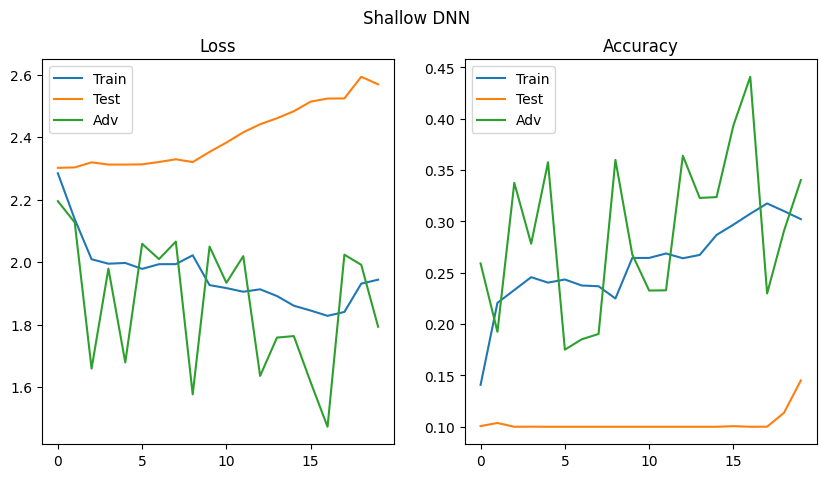

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
2.289105	2.223388	2.280346	0.125860	0.177600	0.134600
2.274123	2.189421	2.270241	0.131920	0.164900	0.133400
2.269320	2.187312	2.266460	0.137360	0.191400	0.146100
2.266372	2.184869	2.260000	0.140000	0.189700	0.141200
2.265744	2.187847	2.259047	0.140480	0.197500	0.137300
2.269697	2.181296	2.266314	0.138080	0.198600	0.146500
2.260098	2.164545	2.249172	0.147360	0.201800	0.168400
2.228083	2.155520	2.110823	0.164980	0.218000	0.197600
2.149412	2.138410	2.117637	0.194060	0.192200	0.237900
2.039524	2.253060	2.098352	0.245400	0.185600	0.246700
1.942692	2.164594	1.801969	0.285880	0.239600	0.336100
1.880148	2.204808	2.073820	0.316000	0.171600	0.247900
1.895796	2.196801	1.891295	0.319860	0.180100	0.320200
1.898528	2.185714	1.783609	0.323740	0.178100	0.356900
1.879339	2.192185	1.855000	0.330820	0.190000	0.342600
1.810103	2.152124	1.741173	0.359620	0.208000	0.382500
1.781836	2.138192	1.759057	0.369360	0.228400	0.383900
1.847060	2

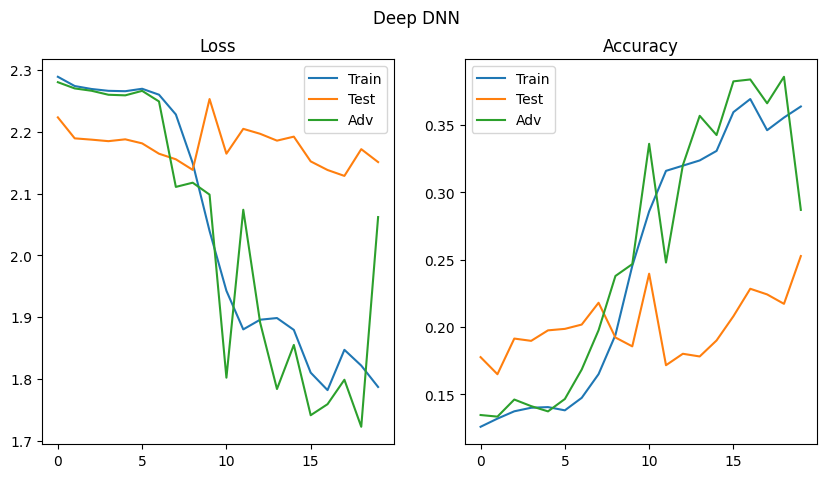

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
2.293558	2.208243	2.264557	0.111840	0.162200	0.135000
2.232547	2.113345	2.155134	0.153840	0.206600	0.186500
1.324977	2.930300	0.902416	0.497980	0.111300	0.657000
0.790423	2.733086	0.540908	0.694260	0.146600	0.806400
0.345843	3.224564	0.256665	0.865580	0.109400	0.906800
0.330147	4.628798	0.367801	0.880820	0.102300	0.863200
0.297729	3.438036	0.155270	0.893460	0.118100	0.944800
0.127512	5.061419	0.107027	0.957120	0.098400	0.965300
0.095261	4.605654	0.093010	0.967980	0.099600	0.967000
0.105636	6.148484	0.134805	0.962880	0.099700	0.951200
0.225510	3.358209	0.499311	0.921440	0.114300	0.821700
0.270663	3.131732	0.151216	0.906120	0.140100	0.949000
0.165773	3.592069	0.119112	0.942080	0.130000	0.961200
0.130148	3.248505	0.108859	0.955900	0.124800	0.962700
0.129815	4.617479	0.083773	0.954520	0.105100	0.970100
0.084018	6.541386	0.072443	0.971380	0.104600	0.975500
0.070916	6.109365	0.076257	0.975000	0.110800	0.972600
0.067574	6

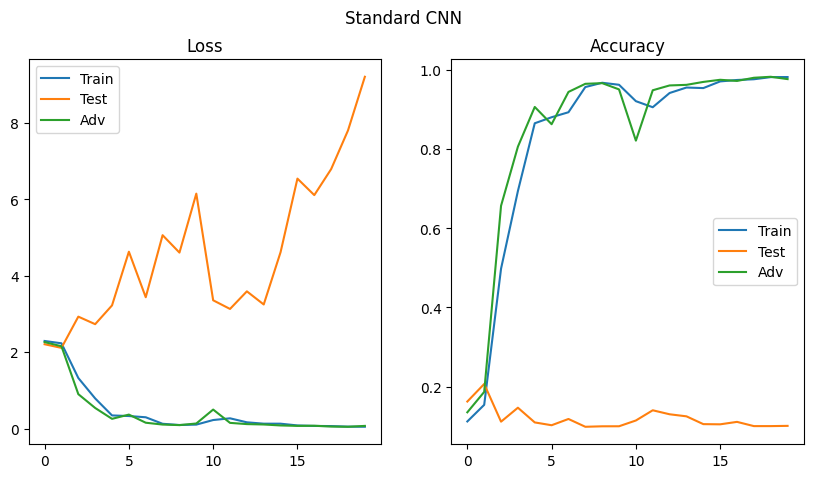

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
2.241530	1.958679	2.217217	0.160140	0.340100	0.177200
2.210520	1.936955	2.192478	0.173560	0.339800	0.189200
2.191682	1.917828	2.188497	0.182600	0.365700	0.190800
2.173480	1.887086	2.173161	0.191620	0.357600	0.193300
2.137368	1.780734	2.127923	0.208340	0.398300	0.210600
2.071026	1.727561	1.983959	0.239180	0.406100	0.279000
1.934926	1.651286	1.870813	0.295320	0.420100	0.326500
1.845444	1.623952	1.694073	0.332300	0.419100	0.396700
1.754231	1.545906	1.688777	0.368800	0.456900	0.396100
1.684916	1.547922	1.645815	0.394860	0.447200	0.412800
1.611352	1.491778	1.565831	0.419360	0.474200	0.440700
1.553388	1.463423	1.583545	0.443020	0.480200	0.430800
1.518190	1.429314	1.527983	0.458380	0.492800	0.452500
1.488524	1.436000	1.503324	0.468700	0.492400	0.465300
1.452812	1.393218	1.507588	0.481780	0.508400	0.463500
1.426965	1.492257	1.455270	0.493340	0.476400	0.484200
1.417409	1.381926	1.453765	0.496480	0.520000	0.487100
1.403696	1

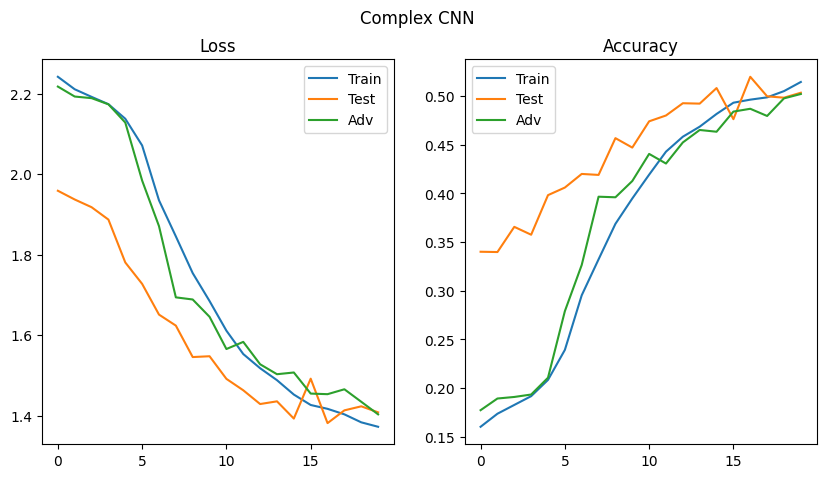

In [13]:
#train the models
for model, optimizer, name in models:
    train_losses, test_losses, adv_losses, train_accuracies, test_accuracies, adv_accuracies = train_robust_model(model, train_loader, test_loader, nn.CrossEntropyLoss(), optimizer, 20, fgsm, 0.1)
    #plot the training curves
    
    plot_model_training(train_losses, test_losses, adv_losses ,train_accuracies, test_accuracies, adv_accuracies, name)

### Now we have trained 4 robust models, let's evaluate each of the models against attack methods and compare the results.

In [14]:
#define the models

#Define 4 different models for evaluation

regular_model_shallow_dnn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
regular_shallow_dnn_optimizer = optim.Adam(regular_model_shallow_dnn.parameters(), lr=0.001)

regular_model_deep_dnn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
regular_deep_dnn_optimizer = optim.Adam(regular_model_deep_dnn.parameters(), lr=0.001)

regular_model_standard_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(1600, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
regular_standard_cnn_optimizer = optim.Adam(regular_model_standard_cnn.parameters(), lr=0.001)

#include some dropout layers and batch normalization
regular_model_complex_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.5),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.5),
    nn.Flatten(),
    nn.Linear(1600, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
regular_complex_cnn_optimizer = optim.Adam(regular_model_complex_cnn.parameters(), lr=0.001)

regular_models = [
    (regular_model_shallow_dnn, regular_shallow_dnn_optimizer, "Shallow DNN"),
    (regular_model_deep_dnn, regular_deep_dnn_optimizer, "Deep DNN"),
    (regular_model_standard_cnn, regular_standard_cnn_optimizer, "Standard CNN"),
    (regular_model_complex_cnn, regular_complex_cnn_optimizer, "Complex CNN")
]

#load the models from the previous training at models/
regular_model_shallow_dnn.load_state_dict(torch.load("models/regular_model_shallow_dnn_CIFAR.pth"))
regular_model_deep_dnn.load_state_dict(torch.load("models/regular_model_deep_dnn_CIFAR.pth"))
regular_model_standard_cnn.load_state_dict(torch.load("models/regular_model_standard_cnn_CIFAR.pth"))
regular_model_complex_cnn.load_state_dict(torch.load("models/regular_model_complex_cnn_CIFAR.pth"))

<All keys matched successfully>

In [15]:
def evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs):
    model.eval()
    test_loss, test_accuracy = adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, **kwargs)
    
    return test_loss, test_accuracy

In [16]:
def evaluate_model_accuracy_for_epsilons(model, data_loader, loss_fn, attack_fn, epsilon_values, **kwargs):
    accuracies = []
    
    for epsilon in epsilon_values:
        _, accuracy = evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs)
        accuracies.append(accuracy)
        
    return accuracies

In [17]:
def compare_regular_model_to_robust_model(regular_model, robust_model, data_loader, loss_fn, attack_args ,attack_functions, title):
    colors = ["b", "g", "r"]
    attacks_methods = ["FGSM", "PGD", "PGD-L2"]
    for i, attack_fn in enumerate(attack_functions):
        epsilon_values = np.linspace(0, 0.3, num=10)
        regular_accuracies = evaluate_model_accuracy_for_epsilons(regular_model, data_loader, loss_fn, attack_fn, epsilon_values, **attack_args[i])
        robust_accuracies = evaluate_model_accuracy_for_epsilons(robust_model, data_loader, loss_fn, attack_fn, epsilon_values, **attack_args[i])
        
        plt.plot(epsilon_values, regular_accuracies, label="{} Regular".format(attacks_methods[i]), color=colors[i], linestyle="--")
        plt.plot(epsilon_values, robust_accuracies, label="{} Robust".format(attacks_methods[i]), color=colors[i])
        plt.xlabel("Epsilon")
        plt.ylabel("Accuracy")
        plt.ylim([0, 1])
        plt.legend()
    plt.title(title)
    plt.show()

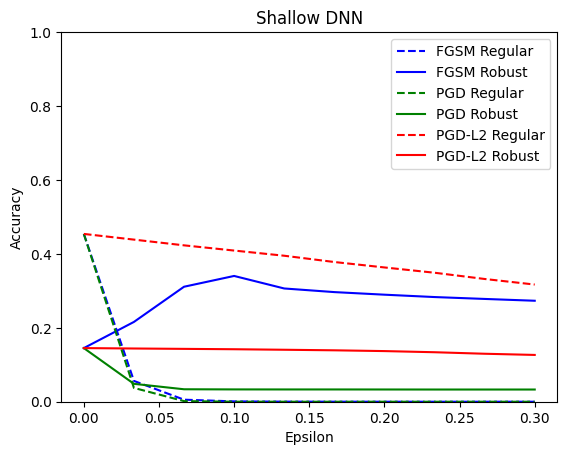

In [18]:
attack_funcs = [fgsm, pgd_linf, pgd_l2]
attack_args = [
    {},
    {"alpha": 0.01, "num_iter": 40},
    {"alpha": 0.01, "num_iter": 40}
]

compare_regular_model_to_robust_model(regular_model_shallow_dnn, model_shallow_dnn, test_loader, nn.CrossEntropyLoss(), attack_args, attack_funcs, "Shallow DNN")

In [19]:
compare_regular_model_to_robust_model(regular_model_deep_dnn, model_deep_dnn, test_loader, nn.CrossEntropyLoss(), attack_args, attack_funcs, "Deep DNN")

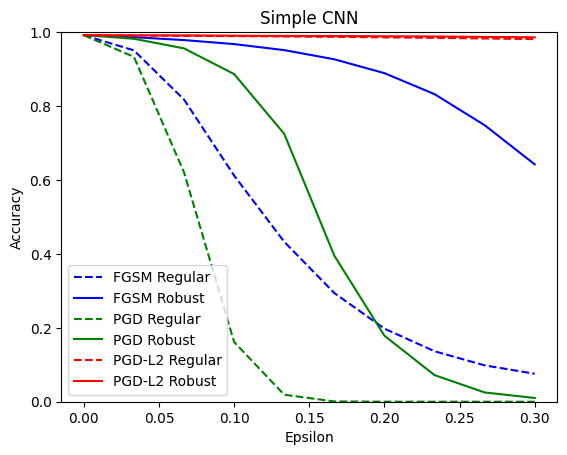

In [ ]:
compare_regular_model_to_robust_model(regular_model_standard_cnn, model_standard_cnn, test_loader, nn.CrossEntropyLoss(), attack_args, attack_funcs, "Simple CNN")

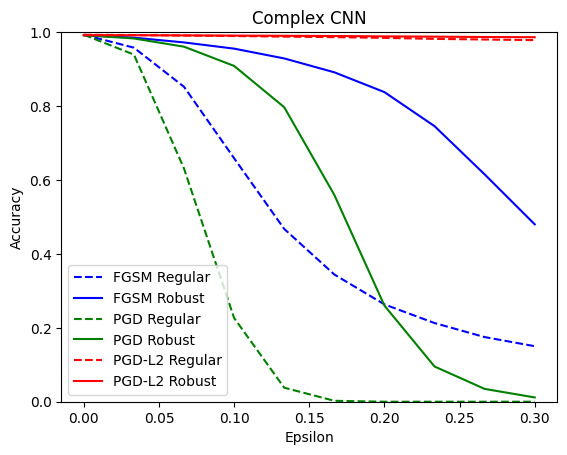

In [ ]:
compare_regular_model_to_robust_model(regular_model_complex_cnn, model_complex_cnn, test_loader, nn.CrossEntropyLoss(), attack_args, attack_funcs, "Complex CNN")